In [34]:
from gym.envs.toy_text import BlackjackEnv
import gym
import matplotlib.pyplot as plt

In [35]:
env = gym.make('Blackjack-v1', render_mode="rgb_array")


def plot_state(env):
    env_screen = env.render()
    fig = plt.figure(figsize=(10, 10), dpi=40)
    ax = fig.add_subplot() 
    ax.imshow(env_screen, interpolation=None)
    plt.axis("off")
    plt.grid(visible=None)
    plt.show()

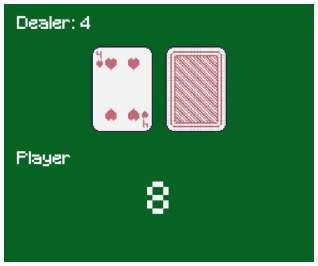

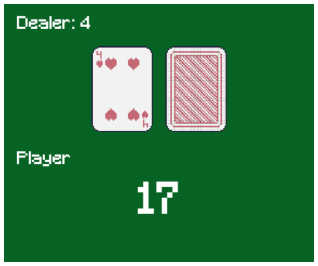

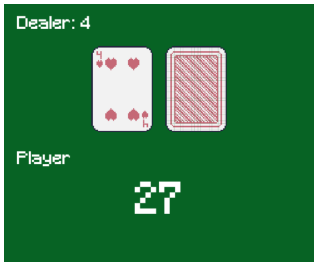

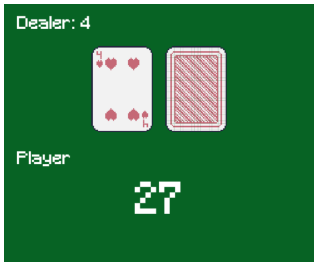

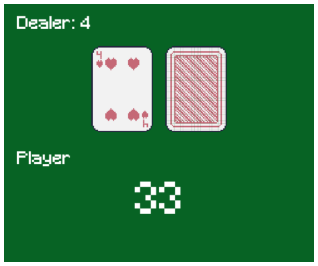

In [36]:
env.reset()

for _ in range(5):
    plot_state(env)
    env.step(env.action_space.sample()) # take a random action

In [37]:
total_rewards = 0
NUM_EPISODES = 1000

for _ in range(NUM_EPISODES):
    env.reset()
    episode_reward = 0
    while env.done == False:
        action = env.action_space.sample()
        new_state, reward, done, desc = env.step(action)
        episode_reward += reward
    total_rewards += episode_reward

avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)

AttributeError: 'BlackjackEnv' object has no attribute 'done'